# GETTING AND LOADING A CORPUS

https://nlpforhackers.io/corpora/
http://lucumr.pocoo.org/2015/11/18/pythons-hidden-re-gems/

The goal of this step is to develop an initial list of each character and their spoken lines, or a cleanish list of the lines within the text. (Dictionaries are Hash value arbitrary, so may not be ordered the same. Lists are used instead.)

In [28]:
# Select and Read a file into "f" using a list and stripping out all Project Gutenberg headers and footers

from pathlib import Path
import re
idx = 1
data_folder = Path("data/murray_kempton/")
file_to_open = data_folder / "Drugs_&_the_CIA.txt"
f = open(file_to_open, 'r')
first_document = list(f)
#print(first_document)

# Determine whether a Project Gutenberg Text
first_header_index = 0
second_header_index = 0
footer_index = 0
if any("GUTENBERG" in s for s in first_document):
    for first_header_index in range( len(first_document) ):
        if ( ( first_document[first_header_index].find('*END*THE SMALL PRINT!') ) != -1 ) :
            break
        else:
            for first_header_index in range( len(first_document) ):
                if ( ( first_document[first_header_index].find('START OF THIS PROJECT GUTENBERG') ) != -1 ) :
                    break        
        
    second_document = list(first_document[first_header_index + 1 :])

    for second_header_index in range( len(second_document) ):
        if ( ( second_document[second_header_index].find('www.gutenberg.org') ) != -1 ) :
            break            
    for footer_index in range( len(first_document) ):
        if ( ( first_document[footer_index].find('End of Project') ) != -1 ) :
            break
        else:
            for footer_index in range( len(first_document) ):
                if ( ( first_document[footer_index].find('End of the Project') ) != -1 ) :
                    break    
        
    print(first_header_index)            
    print(second_header_index)
    print(footer_index)     
    
    script = list()
    if (second_header_index < (first_header_index + 100)):
        script = list(first_document[first_header_index +1 + second_header_index +1 : footer_index-1])
    else:
        script = list(first_document[first_header_index +1 : footer_index-1])
else:
    script = first_document
#print(script)

In [77]:
#Compile a list of speakers
r = re.compile("[A-Z0-9][A-Z0-9]+")
speakers = []
for line in script:
    mtch = r.match(line)
    if mtch:
        speakers.append(mtch.group())
#print(speakers)

#Omit speakers from the list of text
s = re.compile(r"\b[A-Z{3}\.]+\b")
spoken = list(filter(lambda i: not s.search(i), script))

#print(spoken)

# RE-CREATING SENTENCES AND PHRASES

During this step, we concatenate lines in batches to allow the identification of sentences with regular expressions. Then we identify phrases with stop words.

In [30]:
#Concatenate lines into list entries for future sentence splitting

newLines = []
singleLine = ''
singleLines = []

#Remove all line returns(ok)
for j in range(0, len(spoken)):
    spoken[j] = spoken[j].replace('\n', '')
    
#Split 5 lines at a time into new list
for k in range( 0, len(spoken), 3):
    newLines = []
    for line in range( 0, 3 ):
        try:
            newLines.append(' '+spoken[line+k])
        except:
            print("Index Error at", k, line)
            break
    #Join 5-line groups into one line and append to a list
    singleLine = ''.join(newLines)
    singleLines.append(singleLine)

#print(singleLines)

Index Error at 18 2


In [31]:
#Create list of sentences
sentences = []
for m in range(0, len(singleLines)):
    mtch = re.findall("[A-Z][^\.!?]*[\.!?]", singleLines[m], re.M|re.I)
    if mtch:
        sentences.append(mtch)
#print(sentences)

In [32]:
#Clean the stopword list
stoplist = []
clean_line = []
data_folder = Path("data/")
file_to_open = data_folder / "snowball_stop.txt"
f = open(file_to_open, 'r')
full_stop = list(f)

for n in range( 0, len(full_stop), 1 ):
    clean_line = full_stop[n].split('|')
    stoplist.append(clean_line[0])

for p in range(len(stoplist)):
    stoplist[p] = stoplist[p].replace('\n', '')
    
#print(stoplist)

In [33]:
#Create list of phrases using stopwords
phrases = []
candidate_phrases = []

for q in range(len(sentences)):
    for r in sentences[q]:
        words = re.split("\\s+", r)
        previous_stop = False
 
        # examine each word to determine if it is a phrase boundary marker or part of a phrase or alone
        for w in words:
 
            if w in stoplist and not previous_stop:
                # phrase boundary encountered, so put a hard indicator
                candidate_phrases.append(";")
                previous_stop = True
            elif w not in stoplist and len(w) > 3:
                # keep adding words to list until a phrase boundary is detected
                candidate_phrases.append(w.strip())
                previous_stop = False
 
    # get a list of candidate phrases without boundary demarcation
    phrases = re.split(";+", ' '.join(candidate_phrases))

# Clean up phrases    
re2 = re.compile('[^\.!?,"(){}\*:]*[\.!?,"(){}\*:]')
for s in range(len(phrases)):
    phrases[s] = re.sub(re2, '', phrases[s])
    phrases[s] = phrases[s].strip(' ')
    phrases[s] = phrases[s].replace(' ', '_')
    phrases[s] = phrases[s].replace('__', '_')
    phrases[s] = phrases[s].strip('_')

for s in range(len(phrases)):
    try:
        phrases.remove('')
        phrases.remove(' ')
        phrases.remove('/n')
    except:
        pass
    
#for t in range(len(phrases)):
    #print(phrases[t])

# PERFORM A PHRASE FREQUENCY COUNT

Now we can identify common phrases by performing a frequency count on each phrase.  Moreover, if the corpus is large enough, commonly used phrases will be evident with higher counts across many texts.  For this reason the phrase list along with counts, will be stored in a file.

In [34]:
# Phrase frequency count
from operator import itemgetter
wordfreq = []
for u in range(len(phrases)):
    utterance = phrases[u]
    uttcnt = 0
    uttcnt = phrases.count(utterance)
    if uttcnt > 1:
        wordfreq.append(uttcnt)
    
zipped = list(zip(phrases, wordfreq))
sortzip = sorted(zipped, key=itemgetter(1), reverse=True)

for v in range(len(sortzip)):
    print(sortzip[v])

('full_quarter', 2)
('Yorkers', 2)


# Term Frequency–Inverse Document Frequency (TF-IDF)
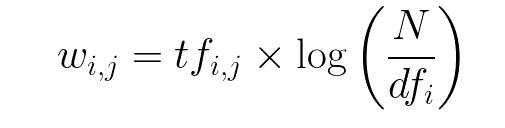


In [35]:
#Establish wordList
wordList = []
for u in range(len(sentences)):
    for v in sentences[u]:
        words = re.split("\\s+", v)
        wordList.extend(words)
    
#wordList = re.split(";+", ' '.join(wordList))
print(wordList)

['The', 'New', 'York', 'Times’s', 'Tim', 'Golden', 'noted', 'recently*', 'that', 'a', 'full', 'quarter', 'of', 'the', 'New', 'Yorkers', 'of', 'color', 'sampled', 'in', 'a', '1990', 'poll', 'believed', 'that', 'their', 'own', 'government', '“deliberately', 'makes', 'sure', 'that', 'drugs', 'are', 'easily', 'available', 'in', 'poor', 'black', 'neighborhoods', 'in', 'order', 'to', 'harm', 'black', 'people.', 'This', 'impression', 'of', 'willful', 'official', 'malice', 'was', 'disturbing', 'enough', 'when', 'registered', 'by', 'one', 'out', 'of', 'every', 'four', 'African', 'Americans.', 'But', 'now', 'its', 'contagions', 'seem', 'likely', 'to', 'swell', 'further', 'with', 'a', 'widening', 'spread', 'of', 'reports', 'that', 'the', 'Central', 'Intelligence', 'Agency', 'stimulated', 'the', 'crack', 'epidemic', 'in', 'the', 'inner', 'cities', 'by', 'flooding', 'them', 'with', 'cocaine', 'and', 'using', 'the', 'profits', 'to', 'fund', 'arms', 'for', 'the', 'Nicaraguan', 'contras.', 'And', 'thu

In [75]:
#Establish wordDict
wordDict = {}
for w in range(len(wordList)):
    newWord = wordList[w]
    newWord = newWord.lower()
    newWord = newWord.replace('.', '')
    wordDict[w] = newWord
#print(wordDict)
    
#Perform word counts on dict
countDict = {}
for x in range(len(wordDict)):
    term = wordDict[x]
    count = 1
    for y in range(len(wordDict)):
        try:
            if wordDict[y].find(term) > 0:
                count += 1
        except:
            pass
        countDict[term] = count
print(countDict)    

{'the': 3, 'new': 1, 'york': 1, 'times’s': 1, 'tim': 3, 'golden': 1, 'noted': 1, 'recently*': 1, 'that': 1, 'a': 69, 'full': 1, 'quarter': 1, 'of': 2, 'yorkers': 1, 'color': 1, 'sampled': 1, 'in': 18, '1990': 1, 'poll': 1, 'believed': 1, 'their': 1, 'own': 1, 'government': 1, '“deliberately': 1, 'makes': 1, 'sure': 1, 'drugs': 1, 'are': 3, 'easily': 1, 'available': 1, 'poor': 1, 'black': 1, 'neighborhoods': 1, 'order': 1, 'to': 2, 'harm': 1, 'people': 1, 'this': 1, 'impression': 1, 'willful': 1, 'official': 1, 'malice': 1, 'was': 1, 'disturbing': 1, 'enough': 1, 'when': 1, 'registered': 1, 'by': 1, 'one': 1, 'out': 4, 'every': 1, 'four': 1, 'african': 1, 'americans': 1, 'but': 1, 'now': 1, 'its': 2, 'contagions': 1, 'seem': 1, 'likely': 1, 'swell': 1, 'further': 1, 'with': 1, 'widening': 1, 'spread': 1, 'reports': 1, 'central': 1, 'intelligence': 1, 'agency': 1, 'stimulated': 1, 'crack': 1, 'epidemic': 1, 'inner': 1, 'cities': 1, 'flooding': 1, 'them': 1, 'cocaine': 1, 'and': 2, 'using

In [76]:
# Computes ratio of word's appearances to total words
bow = wordList
bowCount = len(bow) #BOW = Bag of Words
tfDict = {}
for term, count in countDict.items():
    tfDict[term] = count/float(bowCount)
print(tfDict)

{'the': 0.008695652173913044, 'new': 0.002898550724637681, 'york': 0.002898550724637681, 'times’s': 0.002898550724637681, 'tim': 0.008695652173913044, 'golden': 0.002898550724637681, 'noted': 0.002898550724637681, 'recently*': 0.002898550724637681, 'that': 0.002898550724637681, 'a': 0.2, 'full': 0.002898550724637681, 'quarter': 0.002898550724637681, 'of': 0.005797101449275362, 'yorkers': 0.002898550724637681, 'color': 0.002898550724637681, 'sampled': 0.002898550724637681, 'in': 0.05217391304347826, '1990': 0.002898550724637681, 'poll': 0.002898550724637681, 'believed': 0.002898550724637681, 'their': 0.002898550724637681, 'own': 0.002898550724637681, 'government': 0.002898550724637681, '“deliberately': 0.002898550724637681, 'makes': 0.002898550724637681, 'sure': 0.002898550724637681, 'drugs': 0.002898550724637681, 'are': 0.008695652173913044, 'easily': 0.002898550724637681, 'available': 0.002898550724637681, 'poor': 0.002898550724637681, 'black': 0.002898550724637681, 'neighborhoods': 0

In [71]:
# Calculates the weight of rare words across all docs
import math
idfDict = {}
N = len(docList)
idfDict = dict.fromkeys(docList[0].keys(), 0)
for doc in docList:
    for word, val in doc.items():
        if val > 0:
            idfDict[word] += 1
                
for word, val in idfDict.items():
    idfDict[word] = math.log10(N / float(val))
    
return idfDict

NameError: name 'docList' is not defined

In [ ]:
def computeTFIDF(tfBow, idfs):
    tfidf = {}
    for word, val in tfBow.items():
        tfidf[word] = val*idfs[word]
    return tfidf